In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

import pdb

import simpy
import random
import numpy as np

## A simpler example

In [5]:
def car(env, num):
     while True:
         print('Car # %d: Park at at %d' % (num, env.now))
         parking_duration = 2 + random.randint(0, 3)
         yield env.timeout(parking_duration)

         print('Car # %d: Drive at %d'   % (num, env.now))
         trip_duration = 20 + random.randint(0, 6)
         yield env.timeout(trip_duration)

### Simulate just one car

In [6]:
env = simpy.Environment()
env.process(car(env, 1))
env.run(until=150)

Car # 1: Park at at 0
Car # 1: Drive at 4
Car # 1: Park at at 30
Car # 1: Drive at 33
Car # 1: Park at at 53
Car # 1: Drive at 55
Car # 1: Park at at 81
Car # 1: Drive at 83
Car # 1: Park at at 106
Car # 1: Drive at 110
Car # 1: Park at at 134
Car # 1: Drive at 136


In [7]:
env = simpy.Environment()
env.process(car(env, 1))
env.process(car(env, 2))
env.process(car(env, 3))
env.run(until=150)

Car # 1: Park at at 0
Car # 2: Park at at 0
Car # 3: Park at at 0
Car # 2: Drive at 2
Car # 3: Drive at 2
Car # 1: Drive at 5
Car # 2: Park at at 22
Car # 2: Drive at 24
Car # 3: Park at at 25
Car # 3: Drive at 28
Car # 1: Park at at 31
Car # 1: Drive at 36
Car # 2: Park at at 45
Car # 2: Drive at 47
Car # 3: Park at at 51
Car # 3: Drive at 53
Car # 1: Park at at 58
Car # 1: Drive at 61
Car # 2: Park at at 67
Car # 2: Drive at 70
Car # 3: Park at at 74
Car # 3: Drive at 78
Car # 1: Park at at 83
Car # 1: Drive at 88
Car # 2: Park at at 94
Car # 3: Park at at 98
Car # 2: Drive at 98
Car # 3: Drive at 102
Car # 1: Park at at 112
Car # 1: Drive at 114
Car # 2: Park at at 122
Car # 3: Park at at 125
Car # 2: Drive at 126
Car # 3: Drive at 128
Car # 1: Park at at 138
Car # 1: Drive at 140
Car # 2: Park at at 148


## A more complex ecology inspired example with a scarce resource

In [8]:
"""
A forest has 3 lakes, each of which can accommodate 2 individual animals at once. 
There are prey and predator animals. When not drinking, the predator animals eat prey
animals when the prey cross their paths. When not drinking, the prey animals
are either reproducing  (asexually) or bumping into predators and being eaten.
"""

MTTD               = 600.0 # mean time before an animal needs to drink after drinking
DRINK_MIN          = 120.0 # min time between drinks from the lake
DRINK_MEAN         = 5.0
DRINK_SIGMA        = 1.0
REPRO_MEAN         = 200.0 # mean time to reproduce
REPRO_SIGMA        = 20.0 # sd of time to reproduce
EAT_MEAN           = 10.0 # mean time to eat prey
EAT_SIGMA          = 1.0 # sd of time to eat prety
TREE_GROW_DURATION = 4000

In [9]:
def time_to_(activity):
    activity_time = 1.0
    if activity == 'go_to_lake_':
        activity_time = random.expovariate(MTTD) + DRINK_MIN
    elif activity == 'drink':
        activity_time =  random.normalvariate(DRINK_MEAN, DRINK_SIGMA)
    elif activity == 'repro':
        activity_time =  random.normalvariate(REPRO_MEAN, REPRO_SIGMA)
    elif activity == 'eat':
        activity_time =  random.normalvariate(EAT_MEAN, EAT_SIGMA)
    return max(activity_time, 1.0)

In [10]:
class Animal(object):
    def __init__(self, env, name, lake):
        self.env            = env
        self.name           = name
        self.offspring_made = 0
        self.thirsty        = False

        self.process = env.process(self.living(lake))
        env.process(self.drink_from_lake())

    def living(self, lake):
        while True:
            # Start making a new part
            done_in = time_to_('eat')
            while done_in:
                try:
                    # Working on the part
                    start = self.env.now
                    #print("started eating = %f and time remaining = %f" % (self.env.now, done_in))
                    yield self.env.timeout(done_in)
                    done_in = 0  # Set to 0 to exit while loop.
                except simpy.Interrupt:
                    self.thirsty = True
                    done_in -= self.env.now - start  # How much time left?

                    # Seek access to the lake, either by waiting for another
                    # animal to finish or displacing a feeding sapling
                    with lake.request(priority=1) as req:
                        yield req
                        drink_time = time_to_('drink')
                        #print("started drinking = %f and time remaining = %f" % (self.env.now, drink_time))
                        yield self.env.timeout(drink_time)
                    self.thirsty = False

            # Start making a new part
            done_in = time_to_('repro')
            while done_in:
                try:
                    # Working on the part
                    start = self.env.now
                    #print("started breeding = %f and time remaining = %f" % (self.env.now, done_in))
                    yield self.env.timeout(done_in)
                    #print("MADE A BABY")
                    self.offspring_made += 1

                    done_in = 0  # Set to 0 to exit while loop.

                except simpy.Interrupt:
                    self.thirsty = True
                    done_in -= self.env.now - start  # How much time left?

                    # Seek access to the lake, either by waiting for another
                    # animal to finish or displacing a feeding sapling
                    with lake.request(priority=1) as req:
                        yield req
                        drink_time = time_to_('drink')
                        #print("started drinking = %f and time remaining = %f" % (self.env.now, drink_time))
                        yield self.env.timeout(drink_time)

                    self.thirsty = False
                    
    def drink_from_lake(self):
        """go drink at capacity limited lake from time to time"""
        while True:
            yield self.env.timeout(30)
            ##yield self.env.timeout(time_to_('go_to_lake'))
            if not self.thirsty:
                # Only drink if currently not drinking from lake
                self.process.interrupt()


In [11]:
def other_water_uses(env, lake):
    """The lake also nourishes plants"""
    while True:
        # Start a new job
        done_in = TREE_GROW_DURATION
        while done_in:
            # Retry the job until it is done.
            # It's priority is lower than that of machine repairs.
            with lake.request(priority=2) as req:
                yield req
                try:
                    start = env.now
                    yield env.timeout(done_in)
                    TREES_GROWN = TREES_GROWN + 1
                    done_in = 0
                except simpy.Interrupt:
                    done_in -= env.now - start



In [12]:
# Setup and start the simulation
SIM_TIME = 1000
RANDOM_SEED = 1142
TREES_GROWN = 0
LAKE_CAPACITY = 6
NUM_ANIMALS = 2

random.seed(RANDOM_SEED)  # This helps reproducing the results

# Create an environment and start the setup process
env = simpy.Environment()

lake = simpy.PreemptiveResource(env, capacity=LAKE_CAPACITY)
animals = [Animal(env, 'Animal %d' % i, lake) for i in range(NUM_ANIMALS)]

env.process(other_water_uses(env, lake))

# Execute!
env.run(until=SIM_TIME)

# Analyis/results
print('Lake results')
for animal in animals:
    print('%s made %d offspring.' % (animal.name, animal.offspring_made))
    


Lake results
Animal 0 made 4 offspring.
Animal 1 made 3 offspring.


### Exercise: consider an extreme situation that might lead to fewer offspring even as there are more animals. How can we test this by modifying the code above?

In [13]:
NUM_ANIMALS = 200

random.seed(RANDOM_SEED)  # This helps reproducing the results

# Create an environment and start the setup process
env = simpy.Environment()

lake = simpy.PreemptiveResource(env, capacity=LAKE_CAPACITY)
animals = [Animal(env, 'Animal %d' % i, lake) for i in range(NUM_ANIMALS)]

env.process(other_water_uses(env, lake))

# Execute!
env.run(until=SIM_TIME)

# Analyis/results
print('Lake results')
for animal in animals:
    print('%s made %d offspring.' % (animal.name, animal.offspring_made))
    

Lake results
Animal 0 made 0 offspring.
Animal 1 made 0 offspring.
Animal 2 made 0 offspring.
Animal 3 made 0 offspring.
Animal 4 made 0 offspring.
Animal 5 made 0 offspring.
Animal 6 made 0 offspring.
Animal 7 made 0 offspring.
Animal 8 made 0 offspring.
Animal 9 made 0 offspring.
Animal 10 made 0 offspring.
Animal 11 made 0 offspring.
Animal 12 made 0 offspring.
Animal 13 made 0 offspring.
Animal 14 made 0 offspring.
Animal 15 made 0 offspring.
Animal 16 made 0 offspring.
Animal 17 made 0 offspring.
Animal 18 made 0 offspring.
Animal 19 made 0 offspring.
Animal 20 made 0 offspring.
Animal 21 made 0 offspring.
Animal 22 made 0 offspring.
Animal 23 made 0 offspring.
Animal 24 made 0 offspring.
Animal 25 made 0 offspring.
Animal 26 made 0 offspring.
Animal 27 made 0 offspring.
Animal 28 made 0 offspring.
Animal 29 made 0 offspring.
Animal 30 made 0 offspring.
Animal 31 made 0 offspring.
Animal 32 made 0 offspring.
Animal 33 made 0 offspring.
Animal 34 made 0 offspring.
Animal 35 made 0 

### Exercise: How would you determine the number of offspring produced by the sim as a function of the number of animals?

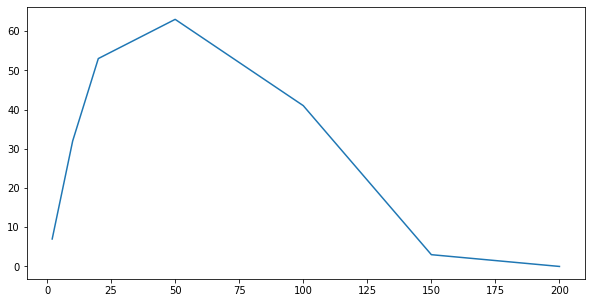

In [14]:
num_offspring = []
num_animals = [2, 10, 20, 50, 100, 150, 200]
for num in num_animals:
    # Create an environment and start the setup process
    env = simpy.Environment()

    lake = simpy.PreemptiveResource(env, capacity=LAKE_CAPACITY)
    animals = [Animal(env, 'Animal %d' % i, lake) for i in range(num)]

    env.process(other_water_uses(env, lake))

    # Execute!
    env.run(until=SIM_TIME)

    this_offspring = 0
    for animal in animals:
        this_offspring += animal.offspring_made
    num_offspring.append(this_offspring)
    
plt.plot(num_animals, num_offspring)

In [15]:
num_offspring

[7, 32, 53, 63, 41, 3, 0]

### Exercise: Can we put in some 'learning' in this model? 
#### How can we code animals that get smarter over time?


In [16]:
class SmartAnimal(object):
    def __init__(self, env, name, lake):
        self.env            = env
        self.name           = name
        self.offspring_made = 0
        self.thirsty        = False
        self.experience     = 0

        self.process = env.process(self.living(lake))
        env.process(self.drink_from_lake())

    def living(self, lake):
        while True:
            # Start making a new part
            done_in = time_to_('eat')
            while done_in:
                try:
                    # Working on the part
                    start = self.env.now
                    #print("started eating = %f and time remaining = %f" % (self.env.now, done_in))
                    yield self.env.timeout(done_in)
                    done_in = 0  # Set to 0 to exit while loop.
                except simpy.Interrupt:
                    self.experience += 1
                    self.thirsty     = True
                    done_in         -= self.env.now - start  # How much time left?

                    if self.experience > 2:
                        self.experience -= 1
                        print("with experience, decided to skip drinking")
                    else:
                    
                        # Seek access to the lake, either by waiting for another
                        # animal to finish or displacing a feeding sapling
                        with lake.request(priority=1) as req:
                            yield req
                            drink_time = time_to_('drink')
                            #print("started drinking = %f and time remaining = %f" % (self.env.now, drink_time))
                            yield self.env.timeout(drink_time)
                    self.thirsty = False

            # Start making a new part
            done_in = time_to_('repro')
            while done_in:
                try:
                    # Working on the part
                    start = self.env.now
                    #print("started breeding = %f and time remaining = %f" % (self.env.now, done_in))
                    yield self.env.timeout(done_in)
                    #print("MADE A BABY")
                    self.offspring_made += 1

                    done_in = 0  # Set to 0 to exit while loop.

                except simpy.Interrupt:
                    self.thirsty = True
                    done_in -= self.env.now - start  # How much time left?

                    # Seek access to the lake, either by waiting for another
                    # animal to finish or displacing a feeding sapling
                    with lake.request(priority=1) as req:
                        yield req
                        drink_time = time_to_('drink')
                        #print("started drinking = %f and time remaining = %f" % (self.env.now, drink_time))
                        yield self.env.timeout(drink_time)

                    self.thirsty = False
                    
    def drink_from_lake(self):
        """go drink at capacity limited lake from time to time"""
        while True:
            yield self.env.timeout(30)
            ##yield self.env.timeout(time_to_('go_to_lake'))
            if not self.thirsty:
                # Only drink if currently not drinking from lake
                self.process.interrupt()


with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip d

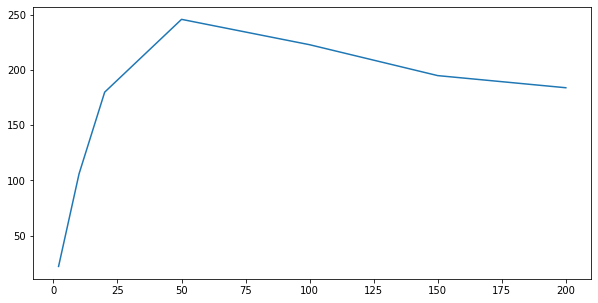

In [17]:
num_offspring = []
num_animals = [2, 10, 20, 50, 100, 150, 200]
for num in num_animals:
    # Create an environment and start the setup process
    env = simpy.Environment()

    lake = simpy.PreemptiveResource(env, capacity=LAKE_CAPACITY)
    animals = [SmartAnimal(env, 'Animal %d' % i, lake) for i in range(num)]

    env.process(other_water_uses(env, lake))

    # Execute!
    env.run(until=SIM_TIME*3)

    this_offspring = 0
    for animal in animals:
        this_offspring += animal.offspring_made
    num_offspring.append(this_offspring)
    
plt.plot(num_animals, num_offspring)

In [18]:
num_offspring

[22, 106, 180, 246, 223, 195, 184]

#### Can we think of a way so that some but not all animals get smarter/better over time?

In [19]:
class SomeSmartAnimal(object):
    def __init__(self, env, name, lake):
        self.env            = env
        self.name           = name
        self.offspring_made = 0
        self.thirsty        = False
        self.experience     = 0
        self.can_learn      = np.random.randint(0, 2)

        self.process = env.process(self.living(lake))
        env.process(self.drink_from_lake())

    def living(self, lake):
        while True:
            # Start making a new part
            done_in = time_to_('eat')
            while done_in:
                try:
                    # Working on the part
                    start = self.env.now
                    #print("started eating = %f and time remaining = %f" % (self.env.now, done_in))
                    yield self.env.timeout(done_in)
                    done_in = 0  # Set to 0 to exit while loop.
                except simpy.Interrupt:
                    if self.can_learn:
                        self.experience += 1
                        
                    self.thirsty     = True
                    done_in         -= self.env.now - start  # How much time left?

                    if self.experience > 2:
                        self.experience -= 1
                        print("with experience, decided to skip drinking")
                    else:
                    
                        # Seek access to the lake, either by waiting for another
                        # animal to finish or displacing a feeding sapling
                        with lake.request(priority=1) as req:
                            yield req
                            drink_time = time_to_('drink')
                            #print("started drinking = %f and time remaining = %f" % (self.env.now, drink_time))
                            yield self.env.timeout(drink_time)
                    self.thirsty = False

            # Start making a new part
            done_in = time_to_('repro')
            while done_in:
                try:
                    # Working on the part
                    start = self.env.now
                    #print("started breeding = %f and time remaining = %f" % (self.env.now, done_in))
                    yield self.env.timeout(done_in)
                    #print("MADE A BABY")
                    self.offspring_made += 1

                    done_in = 0  # Set to 0 to exit while loop.

                except simpy.Interrupt:
                    self.thirsty = True
                    done_in -= self.env.now - start  # How much time left?

                    # Seek access to the lake, either by waiting for another
                    # animal to finish or displacing a feeding sapling
                    with lake.request(priority=1) as req:
                        yield req
                        drink_time = time_to_('drink')
                        #print("started drinking = %f and time remaining = %f" % (self.env.now, drink_time))
                        yield self.env.timeout(drink_time)

                    self.thirsty = False
                    
    def drink_from_lake(self):
        """go drink at capacity limited lake from time to time"""
        while True:
            yield self.env.timeout(30)
            ##yield self.env.timeout(time_to_('go_to_lake'))
            if not self.thirsty:
                # Only drink if currently not drinking from lake
                self.process.interrupt()


with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip drinking
with experience, decided to skip d

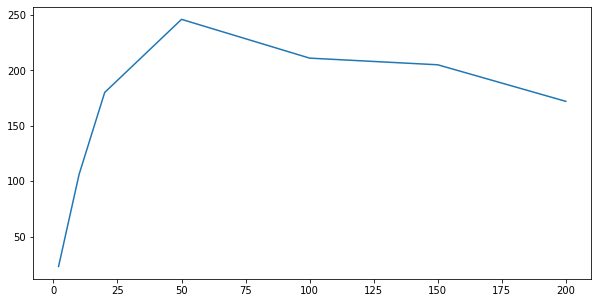

In [20]:
num_offspring = []
num_animals = [2, 10, 20, 50, 100, 150, 200]
for num in num_animals:
    # Create an environment and start the setup process
    env = simpy.Environment()

    lake = simpy.PreemptiveResource(env, capacity=LAKE_CAPACITY)
    animals = [SomeSmartAnimal(env, 'Animal %d' % i, lake) for i in range(num)]

    env.process(other_water_uses(env, lake))

    # Execute!
    env.run(until=SIM_TIME*3)

    this_offspring = 0
    for animal in animals:
        this_offspring += animal.offspring_made
    num_offspring.append(this_offspring)
    
plt.plot(num_animals, num_offspring)

In [21]:
num_offspring

[23, 106, 180, 246, 211, 205, 172]

### Exercise: Take a look at SimPy's API. How could we add a meaningful constraint to the water levels in lake?